In [1]:
using Pkg
Pkg.activate("../")

 Activating environment at `~/Documents/Catlab/AlgebraicDynamics.jl/Project.toml`


In [2]:
using AlgebraicDynamics
using AlgebraicDynamics.UWDDynam
using AlgebraicDynamics.DWDDynam

┌ Info: Precompiling AlgebraicDynamics [5fd6ff03-a254-427e-8840-ba658f502e32]
└ @ Base loading.jl:1260


In [64]:
using Catlab.CategoricalAlgebra
using Catlab.WiringDiagrams
using Catlab.Graphics
using Catlab.Programs

const UWD = UndirectedWiringDiagram

Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:Box, :Port, :OuterPort, :Junction),(:box, :junction, :outer_junction),(2, 2, 3),(1, 4, 4)},Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:Box, :Port, :OuterPort, :Junction),(:box, :junction, :outer_junction),(2, 2, 3),(1, 4, 4)},(:Name, :VarName),(:name, :variable),(1, 4),(1, 2)},Tuple{Name,VarName},(:box, :junction, :outer_junction, :variable),(:variable,),Tables,Indices} where Indices<:NamedTuple where Tables<:NamedTuple where VarName where Name

In [65]:
using OrdinaryDiffEq
using Plots, Plots.PlotMeasures

## Land Ecosystem

### Composition of resource sharers using undirected wiring diagrams

A standard Lotka Volterra predator-prey model is the composition of three primitive resource sharers:

1. a model of rabbit growth --- this resource sharer has dynamics $\dot r(t) = \alpha r(t)$ and one port which exposes the rabbit population.
2. a model of rabbit/fox predation --- this resource sharer has dynamics $$\dot r(t) = -\beta r(t) f(t), \dot f(t) = \gamma r(t)f(t)$$ and two ports which expose the rabbit and fox populations respectively
3. a model of fox population decline --- this resource sharer has dynamics $\dot f(t) = -\delta f(t)$ and one port which exposes the fox population.

However, there are not two independent rabbit populations --- one that grows and one that gets eaten by foxes. Likewise, there are not two independent fox populations --- one that declines and one that feasts on rabbits. To capture these interactions between the trio of resource sharers, we compose them by identifying the exposed rabbit populations and identifying the exposed fox populations. 

In [95]:
dotr(u,p,t) = p[1]*u
dotrf(u,p,t) = [-p[2]*u[1]*u[2], p[3]*u[1]*u[2]]
dotf(u,p,t) = -p[4]*u

# Define the primitive systems
rabbit_growth = ContinuousResourceSharer{Float64}(1, dotr)
rabbitfox_predation = ContinuousResourceSharer{Float64}(2, dotrf)
fox_decline = ContinuousResourceSharer{Float64}(1, dotf)

# Define the composition pattern
rabbitfox_pattern = @relation (r, f) begin
    r_growth(r)
    predation(r,f)
    fdecline(f)
end

# Compose
rabbitfox_system = oapply(rabbitfox_pattern, [rabbit_growth, rabbitfox_predation, fox_decline])

ContinuousResourceSharer(ℝ^2 → ℝ^2) with 2 exposed ports

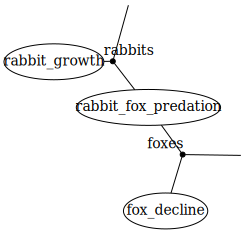

In [240]:
rabbitfox_pattern = @relation (rabbits, foxes)  begin
    rabbit_growth(rabbits)
    rabbit_fox_predation(rabbits,foxes)
    fox_decline(foxes)
end

to_graphviz(rabbitfox_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75")
)

We can now construct an `ODEProblem` from the resource sharer `rabbitfox_system` and plot the solution.

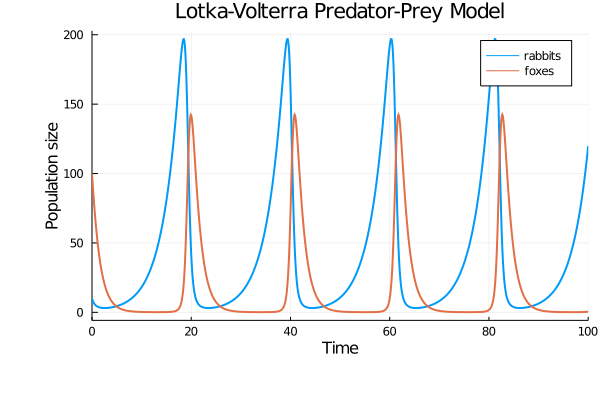

In [151]:
α, β, γ, δ = 0.3, 0.015, 0.015, 0.7
params = [α, β, γ, δ]

u0 = [10.0, 100.0]
tspan = (0.0, 100.0)

prob = ODEProblem(rabbitfox_system, u0, tspan, params)
sol = solve(prob, Tsit5())

plot(sol, lw=2, title = "Lotka-Volterra Predator-Prey Model", bottom_margin=10mm, left_margin=10mm, label=["rabbits" "foxes"])
xlabel!("Time")
ylabel!("Population size")


Suppose we now have a three species ecosystem containing rabbits, foxes, and hawks. Foxes and hawks both prey upon rabbits but do not interact with each other. This ecosystem consists of five primitive systems which share variables: 
1. rabbit growth - $\dot r(t) = \alpha r(t)$
2. rabbit/fox predation - $\dot r(t) = -\beta r(t) f(t), \dot f(t) = \delta r(t)f(t)$
3. fox decline - $\dot f(t) = -\gamma f(t)$
4. rabbit/hawk predation - $\dot r(t) = -\beta' r(t)h(t), \dot h(t) = \delta' r(t)h(t)$
5. hawk decline - $\dot h(t) = -\gamma' h(t)$

This means the desired composition pattern has five boxes and many ports and wires to keep track of. Instead of implementing this composition pattern by hand we construct it as a pushout.


In [241]:
# Define the composition pattern for rabbit growth
rabbit_pattern = @relation (rabbits,) -> rabbit_growth(rabbits)

ACSet with elements Box = 1:1, Port = 1:1, OuterPort = 1:1, Junction = 1:1
┌─────┬───────────────┐
│ Box │          name │
├─────┼───────────────┤
│   1 │ rabbit_growth │
└─────┴───────────────┘
┌──────┬─────┬──────────┐
│ Port │ box │ junction │
├──────┼─────┼──────────┤
│    1 │   1 │        1 │
└──────┴─────┴──────────┘
┌───────────┬────────────────┐
│ OuterPort │ outer_junction │
├───────────┼────────────────┤
│         1 │              1 │
└───────────┴────────────────┘
┌──────────┬──────────┐
│ Junction │ variable │
├──────────┼──────────┤
│        1 │  rabbits │
└──────────┴──────────┘

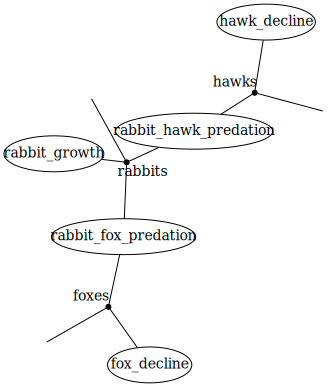

In [247]:

# Define the composition pattern for the rabbit/hawk Lotka Volterra model
rabbithawk_pattern = @relation (rabbits, hawks) begin
    rabbit_growth(rabbits)
    rabbit_hawk_predation(rabbits,hawks)
    hawk_decline(hawks)
end
# Define transformations between the composition patterns
rabbitfox_transform  = ACSetTransformation((Box=[1], Junction=[1], Port=[1], OuterPort=[1]), rabbit_pattern, rabbitfox_pattern)
rabbithawk_transform = ACSetTransformation((Box=[1], Junction=[1], Port=[1], OuterPort=[1]), rabbit_pattern, rabbithawk_pattern)

# Take the pushout
rabbitfoxhawk_pattern = ob(pushout(rabbitfox_transform, rabbithawk_transform))

to_graphviz(rabbitfoxhawk_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".9"))

In [154]:
# Define the additional primitive systems
dotrh(x, p, t) = [-p[5]*x[1]*x[2], p[6]*x[1]*x[2]]
doth(x, p, t)  = -p[7]*x

rabbithawk_predation = ContinuousResourceSharer{Float64}(2, dotrh)
hawk_decline         = ContinuousResourceSharer{Float64}(1, doth)

# Total composition
land_system = oapply(rabbitfoxhawk_pattern, 
                        [rabbit_growth, rabbitfox_predation, fox_decline, 
                         rabbithawk_predation, hawk_decline])

ContinuousResourceSharer(ℝ^3 → ℝ^3) with 3 exposed ports

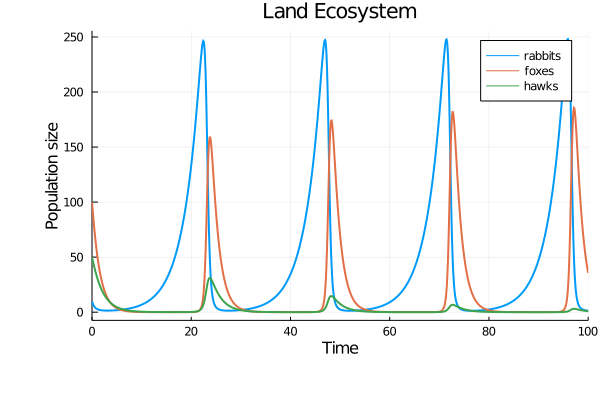

In [155]:
β′, γ′, δ′ = .01, .01, .5
params = vcat(params, [β′, γ′, δ′])

u0 = [10.0, 100.0, 50.0]
tspan = (0.0, 100.0)

prob = ODEProblem(land_system, u0, tspan, params)
sol = solve(prob, Tsit5())

plot(sol, lw=2, title = "Land Ecosystem", bottom_margin=10mm, left_margin=10mm, label=["rabbits" "foxes" "hawks"])
xlabel!("Time")
ylabel!("Population size")

Notice that the hawks are going extinct in this model. We'll have to give hawks something to eat...

## Ocean Ecosystem

Consider a ocean ecosystem containing three species — little fish, big fish, and sharks — with two predation interactions — sharks eat big fish and big fish eat little fish.

This ecosystem can be modeled as the composition of 3 machines:
1. Evolution of the little fish population - this machine has one exogenous variable which represents a population of predators $h(t)$ that hunt little fish. This machine has one output which emits the little fish population. The dynamics of this machine is the driven ODE $$\dot f(t) = \alpha f(t) - \beta f(t)h(t)$$
2. Evolution of the big fish population - this machine has two exogenous variables which represent a population of prey $e(t)$ that are eaten by big fish and a population of predators $h(t)$ which hunt big fish. This machine has one output which emits the big fish population. The dynamics of this machine is the drive ODE $$\dot F(t) = \gamma F(t)e(t) - \delta F(t) - \beta'F(t)h(t)$$
3. Evolution of the shark population - this machine has one exogenous variable which represents a population of prey $e(t)$ that are eaten by sharks. This machine has one output which emits the shark population. The dynamics of this machine is the driven ODE $$\dot s(t) = \gamma's(t)e(t) - \delta's(t)$$

In [156]:
dotfish(f, x, p, t) = [p[1]*f[1] - p[2]*x[1]*f[1]]
dotFISH(F, x, p, t) = [p[3]*x[1]*F[1] - p[4]*F[1] - p[5]*x[2]*F[1]]    # p[1] - prey, p[2] - predator
dotsharks(s, x, p, t) = [p[6]*s[1]*x[1]-p[7]*s[1]]

# Define the primitive systems
fish   = ContinuousMachine{Float64}(1,1,1, dotfish,   f->f)
FISH   = ContinuousMachine{Float64}(2,1,1, dotFISH,   F->F)
sharks = ContinuousMachine{Float64}(1,1,1, dotsharks, s->s)

ContinuousMachine(ℝ^1 × ℝ^1 → ℝ^1)

We compose these machines by (1) sending the output of the big fish machine as the input to both the little fish and shark machines and (2) sending the output of the little fish and shark machines as the inputs to the big fish machine.

In [223]:
# define the composition pattern
ocean_pattern = WiringDiagram([], [])
fish_box = add_box!(ocean_pattern, Box("little fish", [:pop], [:pop]))
Fish_box = add_box!(ocean_pattern, Box("Big Fish", [:pop, :pop], [:pop]))
shark_box = add_box!(ocean_pattern, Box("sharks", [:pop], [:pop]))

add_wires!(ocean_pattern, Pair[
    (fish_box, 1)  => (Fish_box, 1),
    (shark_box, 1) => (Fish_box, 2),
    (Fish_box, 1)  => (fish_box, 1),
    (Fish_box, 1)  => (shark_box, 1)
])

# compose
ocean_system = oapply(ocean_pattern, [fish, FISH, sharks])

ContinuousMachine(ℝ^3 × ℝ^0 → ℝ^3)

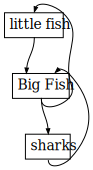

In [239]:
to_graphviz(ocean_pattern, orientation=TopToBottom)

In [159]:
α, β, γ, δ, β′, γ′, δ′ = 0.3, 0.015, 0.015, 0.7, 0.017, 0.017, 0.35
params = [α, β, γ, δ, β′, γ′, δ′]

u0 = [100.0, 10, 2.0]
tspan = (0.0, 100.0)

prob = ODEProblem(ocean_system, u0, tspan, params)
sol = solve(prob, FRK65(0))

plot(sol, lw=2, title = "Ocean Ecosystem", bottom_margin=10mm, left_margin=10mm, label=["little fish" "big fish" "sharks"])
xlabel!("Time")
ylabel!("Population size")

## Total ecosystem
### Another layer of composition

We will introduce a final predation interaction --- hawks eat little fish ---  which will compose the land and ocean ecosystems.

Note that there will be X parameters in to the total system.
- parameters 1-7 will determine the land ecosystem
- parameters 8 and 9 will determine the hawk/little fish predation. Parameter 8 gives the rate of hawk growth and parameter 8 gives the rate of little fish decline.
- parameter 10-16 will determine the ocean ecosystem.


The composition will be as resource shareres so the first thing we will do use the dynamics of the machine `ocean_system` to define dynamics of a resource sharer. We will also define a resource sharer modelling little fish

In [160]:
ocean_system_rs = ContinuousResourceSharer{Float64}(3, (u,p,t)->eval_dynamics(ocean_system, u, [], p[10:16]))

dothf(u,p,t) = [p[8]*u[1]*u[2], -p[9]*u[1]*u[2]]
fishhawk_predation = ContinuousResourceSharer{Float64}(2, dothf)

ContinuousResourceSharer(ℝ^2 → ℝ^2) with 2 exposed ports

In [185]:
# Define the composition pattern
eco_pattern = @relation () where (rabbits, foxes, hawks, littlefish, BigFish, sharks)  begin
    land_eco(rabbits,foxes,hawks)
    hawk_littlefish_predation(hawks, littlefish)
    ocean_eco(littlefish, BigFish, sharks)
end

ACSet with elements Box = 1:3, Port = 1:8, OuterPort = 1:0, Junction = 1:6
┌─────┬───────────────────────────┐
│ Box │                      name │
├─────┼───────────────────────────┤
│   1 │                  land_eco │
│   2 │ hawk_littlefish_predation │
│   3 │                 ocean_eco │
└─────┴───────────────────────────┘
┌──────┬─────┬──────────┐
│ Port │ box │ junction │
├──────┼─────┼──────────┤
│    1 │   1 │        1 │
│    2 │   1 │        2 │
│    3 │   1 │        3 │
│    4 │   2 │        3 │
│    5 │   2 │        4 │
│    6 │   3 │        4 │
│    7 │   3 │        5 │
│    8 │   3 │        6 │
└──────┴─────┴──────────┘
┌──────────┬────────────┐
│ Junction │   variable │
├──────────┼────────────┤
│        1 │    rabbits │
│        2 │      foxes │
│        3 │      hawks │
│        4 │ littlefish │
│        5 │    bigfish │
│        6 │     sharks │
└──────────┴────────────┘

In [186]:
# Compose
eco_system=oapply(eco_pattern, [land_system, fishhawk_predation, ocean_system_rs])

ContinuousResourceSharer(ℝ^6 → ℝ^6) with 0 exposed ports

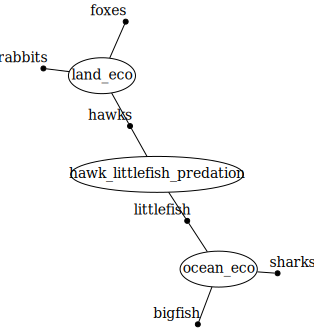

In [248]:
to_graphviz(eco_pattern, box_labels = :name, junction_labels = :variable, edge_attrs=Dict(:len => ".75"))

In [171]:
params = [0.3, 0.015, 0.015, 0.7, .01, .01, .5, 
          0.001, 0.003, 
          0.35, 0.015, 0.015, 0.7, 0.017, 0.017, 0.35]
tspan = (0.0, 30.0)


(0.0, 30.0)

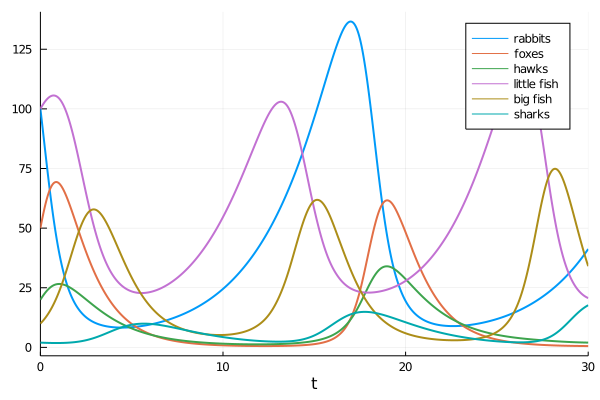

In [172]:
u0 = [100.0, 50.0, 20.0, 100, 10, 2.0]
prob = ODEProblem(eco_system, u0, tspan, params)
sol = solve(prob, Tsit5())
plot(sol, lw=2, label = ["rabbits" "foxes" "hawks" "little fish" "big fish" "sharks"])

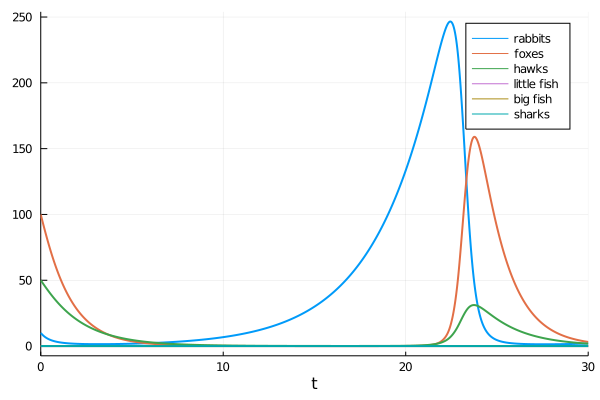

In [173]:
u0 = [10.0, 100.0, 50.0, 0,0,0]
prob = ODEProblem(eco_system, u0, tspan, params)
sol = solve(prob, Tsit5())
plot(sol, lw=2, label = ["rabbits" "foxes" "hawks" "little fish" "big fish" "sharks"])

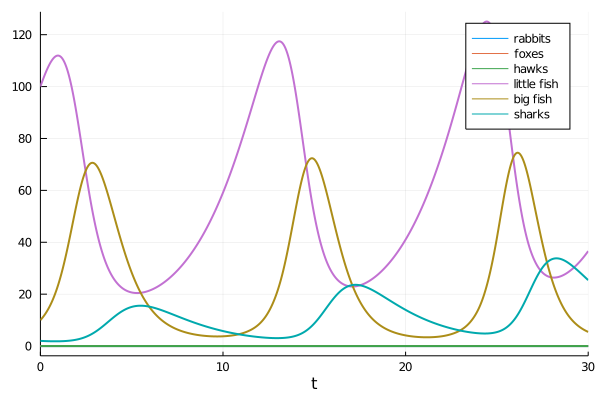

In [174]:
u0 = [0, 0, 0, 100.0, 10, 2.0]
prob = ODEProblem(eco_system, u0, tspan, params)
sol = solve(prob, Tsit5())
plot(sol, lw=2, label = ["rabbits" "foxes" "hawks" "little fish" "big fish" "sharks"])